# Cross validation and variable selection

$\,$

In [1]:
library(tidyverse)
library(sandwich)
library(gridExtra)

theme_update(text = element_text(size=24))
options(repr.plot.width=12, repr.plot.height=6)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



In [3]:
# Create a feature matrix at the grid points x in [0,1] using pmax
# sinusoidal Fourier features
EvalFeatures <- function(x, pmax) {
    n_obs <- length(x)
    freqs <- rep(pi * (1:pmax), each=n_obs)
    f_mat <- matrix(sin(freqs * rep(x, pmax)), nrow=n_obs, ncol=pmax)
    colnames(f_mat) <- paste0("f", 1:pmax)
    return(f_mat)
}

# Draw a regression dataset with
# - n_obs: number of observations
# - sigma_true: residual standard deviation
# - beta_true: regression coefficient
# - x: A set of x in [0,1] at which to evaluate the features, or a uniform draw if null
DrawData <- function(n_obs, sigma_true, beta_true, x=NULL) {
    if (is.null(x)) {        
        x <- runif(n_obs)
    }
    f_mat <- EvalFeatures(x, length(beta_true))
    ey_true <- f_mat %*% beta_true
    y <- ey_true + rnorm(n_obs, sd=sigma_true)
    data_df <- data.frame(f_mat) %>%
        mutate(x=x, y=y, ey_true=ey_true) %>%
        mutate(n=1:n())
    return(data_df)
}


# Select a beta with decaying content at higher frequencies,
# but with only the first p_true components non-zero 
GetBeta <- function(p_true) {
    beta_full <- (runif(pmax) + 0.1) / (1:pmax)
    beta_full <- beta_full / sqrt(sum(beta_full^2))
    beta_true <- rep(0, pmax)
    beta_true[1:p_true] <- beta_full[1:p_true]
    return(beta_true)
}

# Simulated example: A sinusoidal basis

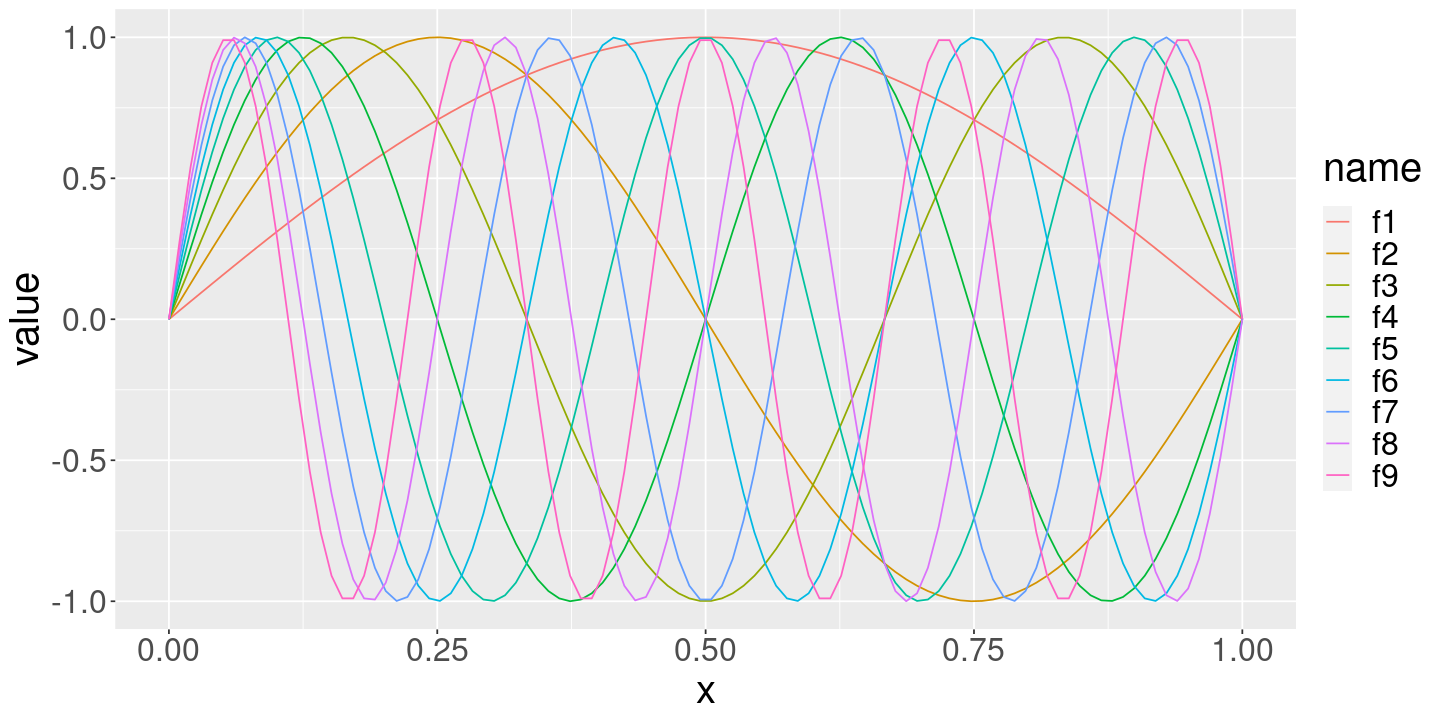

In [4]:
# Construct a basis of sin functions of increasing frequency

pmax <- 50

x_grid <- seq(0, 1, length.out=100)
f_mat <- EvalFeatures(x_grid, pmax)
f_names <- colnames(f_mat)
f_df <- data.frame(f_mat) %>% 
    mutate(x=x_grid) %>% 
    pivot_longer(cols=(-x)) %>%
    mutate(freq=as.numeric(sub("^f", "", name)))
ggplot(f_df %>% filter(freq < 10)) +
    geom_line(aes(x=x, y=value, color=name))

In [5]:
n_obs <- 500
sigma_true <- 0.4

models_df <- data.frame()
for (p_true in seq(1, pmax, 7)) {
    models_df <-
        bind_rows(models_df, DrawData(n_obs, sigma_true, GetBeta(p_true)) %>% 
                  mutate(p_true=p_true))
}

As we increase the number of true regressors, the functions get more
wiggly, since we are including higher–frequency components. Our task is
to try to figure out how wiggly our function should be by trying to
estimate how many regressors to include in the model!

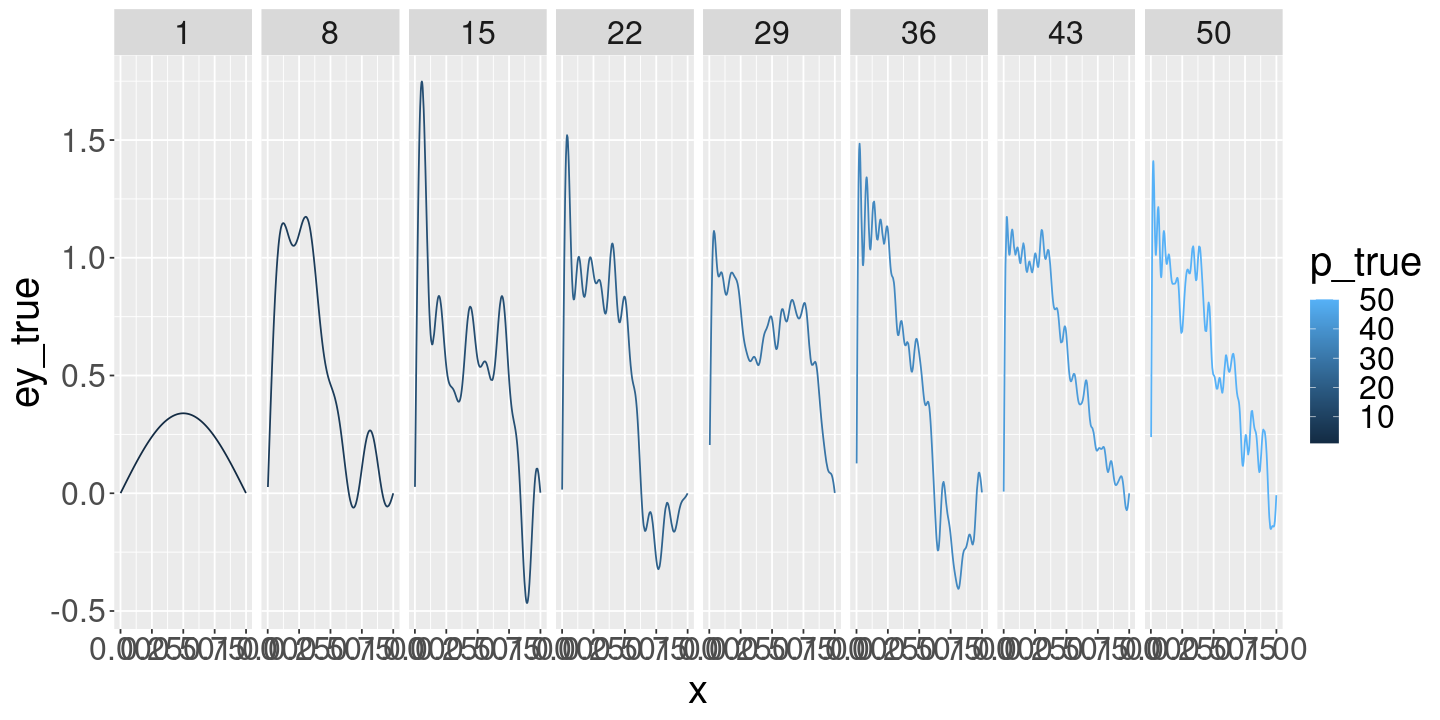

In [6]:
#models_df
ggplot(models_df) +
    geom_line(aes(x=x, y=ey_true, color=p_true)) +
facet_grid(~ p_true)

# Fix a ground truth and run some simulations

We’ll fix a particular number of components, fix our regressors, and
then generate data to see the bias / variance tradeoff.

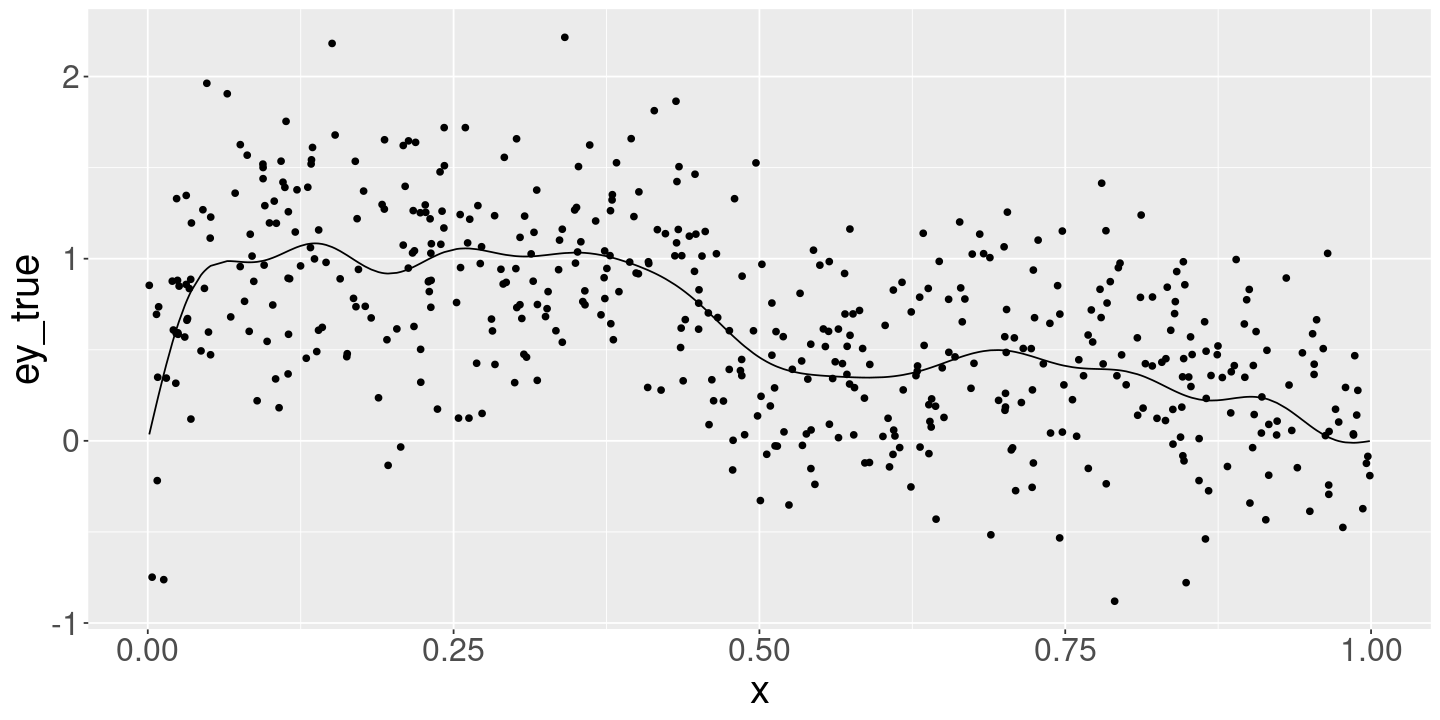

In [7]:
p_true <- 20
beta_true <- GetBeta(p_true)

data_df <- DrawData(n_obs, sigma_true, beta_true)
test_data_df <- DrawData(n_obs, sigma_true, beta_true)

ggplot(data_df) +
    geom_line(aes(x=x, y=ey_true)) +
    geom_point(aes(x=x, y=y))


In [8]:
RegressionFormula <- function(p) {
    stopifnot(p <= pmax)
    form <- sprintf("y ~ -1 + %s", paste(f_names[1:p], collapse=" + "))
    return(form)
}


# Run a regression with the first p predictors and return the fitted values.
ComputePredictions <- function(data_df, p) {
    stopifnot(p <= pmax)
    form <- RegressionFormula(p)
    lm_fit <- lm(formula(form), data_df)
    return(data.frame(y=data_df$y, ey=data_df$ey_true, y_pred=lm_fit$fitted.value, n=data_df$n))
}

Now we run some simulations. For each simulation, we use a new draw of
$y$, but all the same $x$, and all the same $\beta$. For each dataset,
we run regressions for a range of $p$. Because we know the ground truth,
we can compare the predictions to the truth.

In [9]:
n_obs <- 500
sigma_true <- 0.4
n_sims <- 20

# Draw multiple datasets with x fixed (so we can estimate bias and variance)
x <- DrawData(n_obs, sigma_true, beta_true)$x
data_df_list <- lapply(1:n_sims, \(s) DrawData(n_obs, sigma_true, beta_true, x=x))
err_df <- data.frame()

# sanity check that all the datasets have the same x
stopifnot(abs((data_df_list[[1]])$x[1] - (data_df_list[[2]])$x[1]) < 1e-8)

p_seq <- unique(c(1, 2, 3, 4, 5, seq(1, pmax, 5)))
pb <- txtProgressBar(min=0, max=n_sims, style=3)
for (sim in 1:n_sims) {
    setTxtProgressBar(pb, sim)
    for (p in p_seq) {
        data_df <- data_df_list[[sim]]
        pred_df <- ComputePredictions(data_df, p)
        this_err_df <- pred_df %>% mutate(p=p, sim=sim)
        err_df <- bind_rows(err_df, this_err_df)
    }
}
close(pb)


  |======================================================================| 100%

We estimate the different sources of error:

-   `pred_err` = $\hat y_n - \beta^T x_n$
-   `reg_err` = $\hat y_n - \mathbb{E}[\hat\beta]^T x_n$
-   `bias` = $\mathbb{E}[\hat\beta]^T x_n - \beta^T x_n$

so that `pred_err = reg_err + bias`.

In [10]:
# Estimate the expectated prediction at each datapoint (to estimate the bias)
# Recall that n indexes individual datapoints, so ey_pn is an estimate of
# the expected yhat for a particular x, averaged over all simulations.
err_df <-
    err_df %>%
    group_by(p, n) %>%
    mutate(ey_pn=mean(y_pred)) %>%
    ungroup()

# Compute the MSE and related quantities
mse_df <- 
    err_df %>%
    group_by(p) %>%
    mutate(pred_err=y_pred - ey, 
           reg_err=y_pred - ey_pn,
           bias=ey_pn - ey) %>%
    summarize(mse=mean(pred_err^2), 
              var=mean(reg_err^2), 
              bias2=mean(bias^2), # The averaging over new data 
              rand_err=sigma_true^2) %>%
    mutate(mse_check=(mse - (var + bias2)) / mse) # Sanity check -- should be zero

In [11]:
mse_df

Look at how the MSE and its components vary with `p`, the number of
regressors included in the regression.

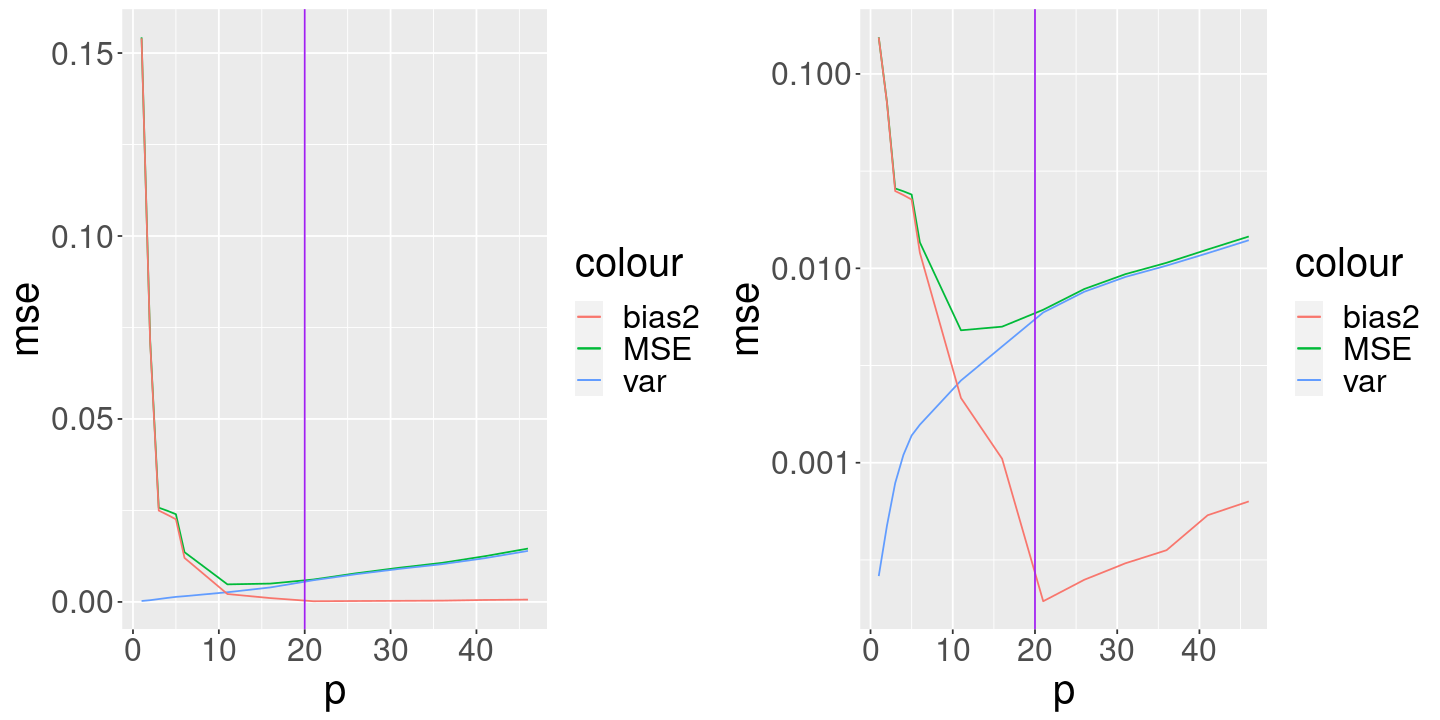

In [12]:
mse_graph <- ggplot(mse_df, aes(x=p)) +
    geom_line(aes(y=mse, color="MSE")) +
    geom_line(aes(y=var, color="var")) +
    geom_line(aes(y=bias2, color="bias2")) +
    geom_vline(aes(xintercept=p_true), color="purple")
grid.arrange(
    mse_graph,
    mse_graph + scale_y_log10(),
    ncol=2)


# Cross-validation

Now let’s see whether we can accurately recover the above curves using
cross-validation.

We’ll use k-fold cross validation. We run the regression once for each
`p`, and once for each simulated dataset, so we can see the variability
in the CV procedure.

In [13]:
# Perform cross-validation.
# `mse` is the estimated held--out fold mean squared error.

n_folds <- 10
fold_index <- sample(1:n_folds, n_obs, replace=TRUE)

err_cv_df <- data.frame()
n_data_sets <- length(data_df_list)
stopifnot(n_data_sets <= length(data_df_list))

pb <- txtProgressBar(min=0, max=length(p_seq) * n_data_sets * n_folds, style=3)
pb_ind <- 0
for (p in p_seq) {
    for (data_ind in 1:n_data_sets) {
        for (fold in 1:n_folds) {
            pb_ind <- pb_ind + 1
            setTxtProgressBar(pb, pb_ind)
            data_df <- data_df_list[[data_ind]] %>% mutate(fold_index=fold_index)
            lm_fit <-lm(formula(RegressionFormula(p)), data_df %>% filter(fold_index != !!fold))
            data_fold_df <- data_df %>% filter(fold_index == !!fold)
            y_pred <- predict(lm_fit, data_fold_df)
            mse <- mean((y_pred - data_fold_df$y)^2)
            
            this_err_cv_df <- data.frame(mse=mse, fold=fold, p=p, data_ind=data_ind)
            err_cv_df <- bind_rows(err_cv_df, this_err_cv_df)
}}}
close(pb)

  |======================================================================| 100%

In [14]:
# For each p, and each dataset, average the mse over folds,
# and identify the p for each dataset that minimizes MSE.
err_cv_agg_df <-
    err_cv_df %>%
        group_by(data_ind, p) %>%
        summarize(mse=mean(mse), .groups="keep") %>%
        ungroup() %>%
        group_by(data_ind) %>%
        mutate(is_mse_min=mse <= min(mse)) 

# For each p, see how variable the mse is over datasets.  
# (In practice, you only see one dataset.)
err_cv_agg_agg_df <-
    err_cv_agg_df %>%
    group_by(p) %>%
    summarize(mse_sd=sd(mse), mse=mean(mse), .groups="drop")

min_ind <- which.min(err_cv_agg_agg_df$mse)
min_mse <- err_cv_agg_agg_df$mse[min_ind]
min_mse_sd <- err_cv_agg_agg_df$mse_sd[min_ind]
min_p <- err_cv_agg_agg_df$p[min_ind]
p_cv <- err_cv_agg_agg_df %>%
    filter(mse <= min_mse + min_mse_sd) %>%
    pull(p) %>%
    min()
print(p_cv)

[1] 6

We see that

-   CV selects more variables than are correct
-   There is a fair amount of variability in the estimated MSE

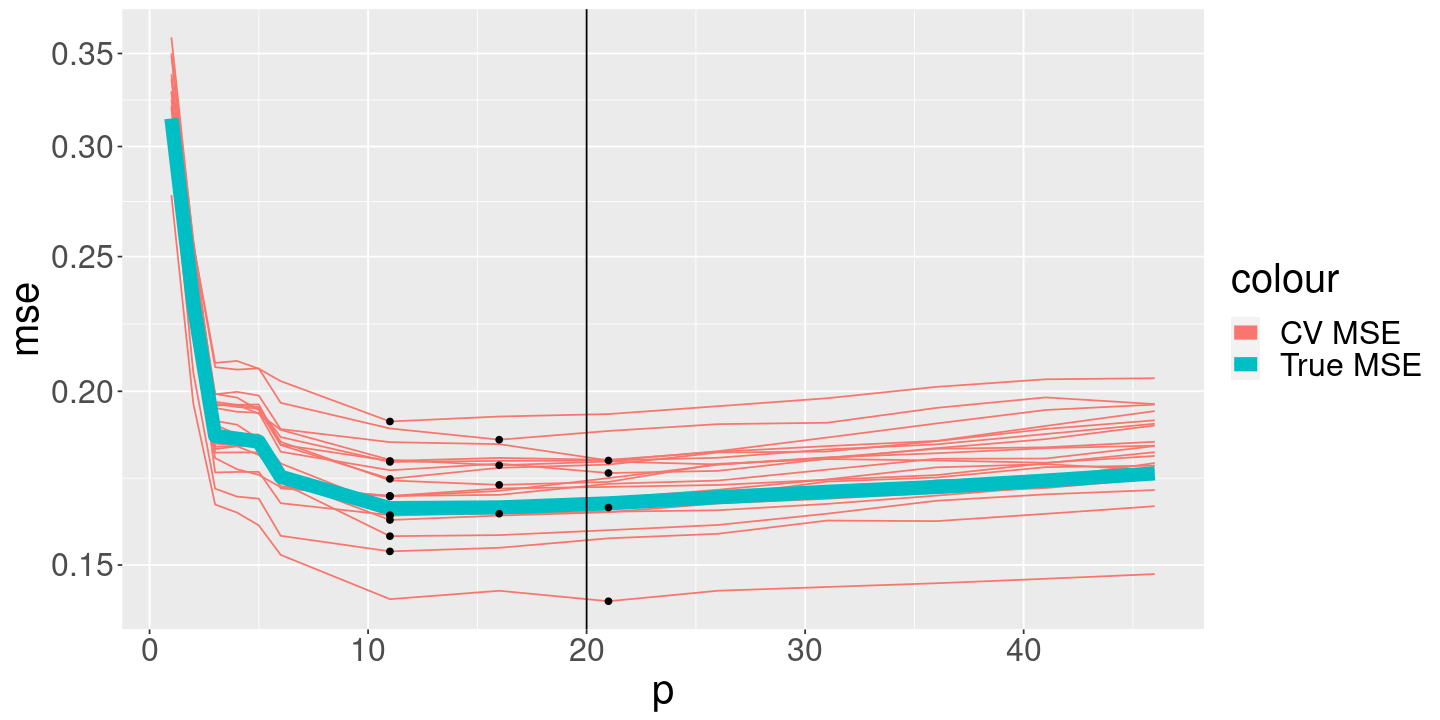

In [15]:
ggplot(err_cv_agg_df, aes(x=p)) +
    geom_line(aes(y=mse, group=data_ind, color="CV MSE")) +
    geom_line(aes(x=p, y=mse + sigma_true^2, color="True MSE"), data=mse_df, lwd=4) +
    geom_point(aes(p, mse), data=filter(err_cv_agg_df, is_mse_min == TRUE)) +
    geom_vline(aes(xintercept=p_true)) +
    scale_y_log10()


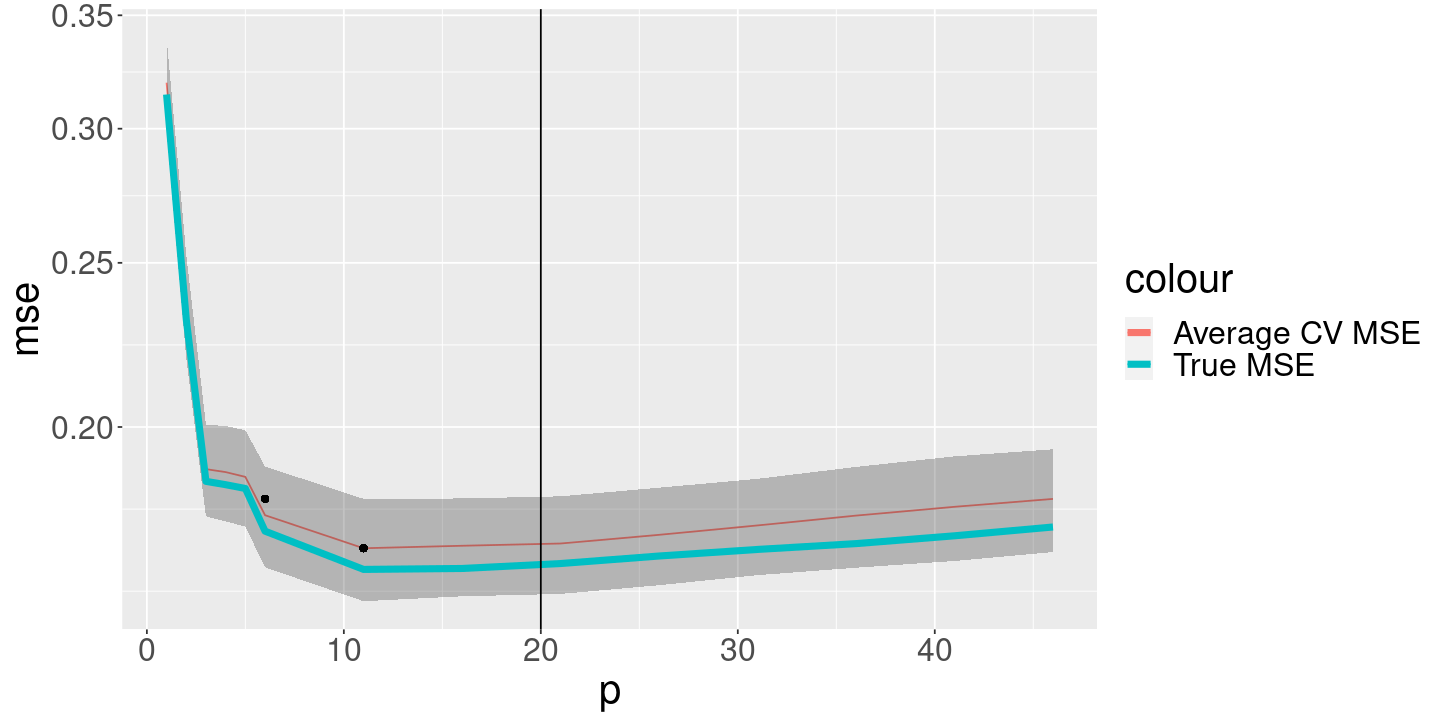

In [16]:


ggplot(err_cv_agg_df, aes(x=p)) +
    geom_line(aes(x=p, y=mse, color="Average CV MSE"), data=err_cv_agg_agg_df) +
    geom_ribbon(aes(x=p, ymin=mse - mse_sd, ymax=mse + mse_sd), data=err_cv_agg_agg_df, alpha=0.3) +
    geom_line(aes(x=p, y=mse + sigma_true^2, color="True MSE"), data=mse_df, lwd=2) +
    geom_point(aes(x=p_cv, y=min_mse + min_mse_sd)) +
    geom_point(aes(x=min_p, y=min_mse)) +
    geom_vline(aes(xintercept=p_true)) +
    scale_y_log10()

